In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import G, M_sun
from scipy.interpolate import interp1d
from matplotlib import colors 
from scipy.integrate import simps
from scipy import interpolate
import astropy.units as u
import tqdm
import numpy as np
import warnings
import os
import sys

sys.path.append('../my_funcs/')
from pipeline_main import pipeline
#from pipeline_stress import _fill_2Dhist
from pipeline_1D import *
from pipeline_stress import _fill_2Dhist

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

### $$\left(\alpha_{\phi z}\rho c_s^2 \right)_\text{w}= \left[\rho v_z\delta v_\phi - \frac{B_zB_\phi}{4\pi} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_z}{4\pi G} \right]_\text{w}$$
### $$v_\phi=r\Omega + \delta v_\phi,\quad\quad *C_s^2 = \frac{P}{\rho}$$
### $$\Leftrightarrow$$
### $$(\rho c_s^2)_\text{mid}\overline{\alpha_{\phi z}} = \left(\rho\alpha_{\phi z} c_s^2 \right)_\text{w}= \left[\rho v_z\delta v_\phi - \frac{B_zB_\phi}{4\pi} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_z}{4\pi G} \right]_\text{w}$$
### (...)$_\text{w}$ signifies the sum of angular momentum flux density carried away at the top and bottom
### The nondimensional stress $\overline{\alpha_{\phi z}}$ is normalized by the density at the midplane $\rho_{mid} = \frac{\Sigma} {\sqrt{\pi}H}$
### $$\Leftrightarrow$$
### $$\overline{\alpha_{\phi z}} = \frac{1}{(\rho c_s^2)_\text{mid}}\left[\rho v_z\delta v_\phi - \frac{B_zB_\phi}{4\pi} + \frac{(\nabla\Phi)_\phi(\nabla\Phi)_z}{4\pi G} \right]_\text{w}$$

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4855/4855 [00:05<00:00, 822.52it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4855/4855 [00:00<00:00, 14448.13it/s]


Disk size: 145.1 au
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4855/4855 [00:00<00:00, 5150.50it/s]


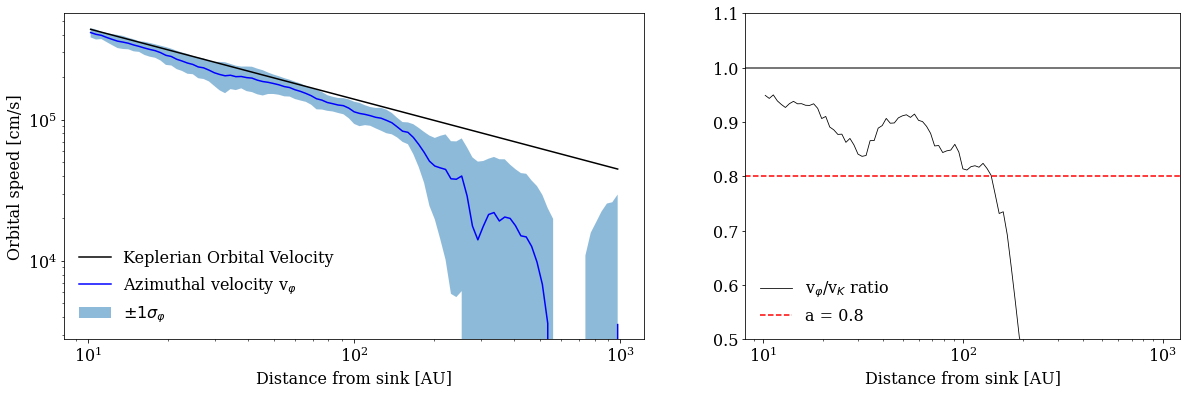

In [2]:
data = pipeline(snap = 535, run = 'sink178core03', sink_id=178)
data.recalc_L(verbose = 1); 
data.calc_disksize(plot = True); data.calc_trans_xyz()

In [3]:
data.to_1D(plot = False, r_in= 5, r_out = 80, Nr = 300)
data.get_1D_param(Ω = True, get_units = False)
data.calc_cs1D(method = 'settled_disk')
radii = data.r_1D

Looping through patches to extract densities and heights
Fitting surface density and scaleheight in each radial bin


100%|██████████| 299/299 [00:03<00:00, 83.82it/s] 


Extracting azimuthal, angular velocities and adiabatic index data from patches into 1D


100%|██████████| 1850/1850 [00:08<00:00, 224.09it/s]

Calculating sound speed assuming a thin settled disk c_s = ΩΗ



/lustre/hpc/astro/kxm508/codes/dispatch2/experiments/ISM/python/stresses/../my_funcs/pipeline_1D.py:187: RuntimeWarning: invalid value encountered in sqrt
  σ_γ = np.sqrt(γ2 - γ**2)


In [4]:
for p in data.sn.patches:
    if p.id == 1853: break
(p.var('d') * data.cgs_density).mean()

7.355885e-22

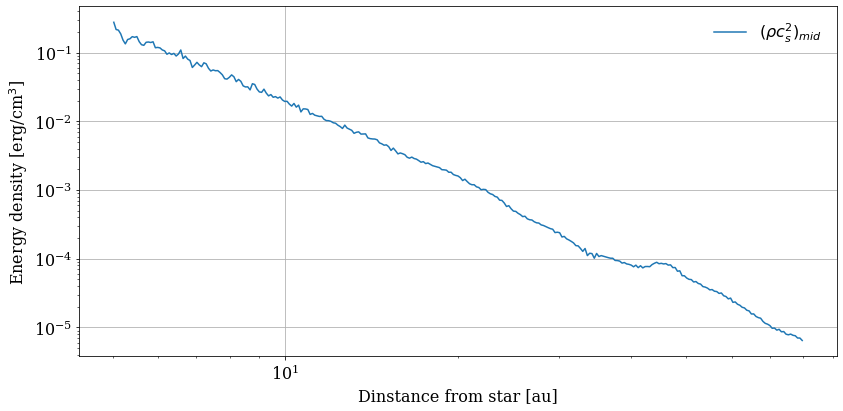

In [5]:
ρ_mid = data.Σ_1D[:,0] / (6 * data.H_1D[:,0] * data.sn.cgs.au)

fig, axs = plt.subplots(figsize = (12,6))
axs.grid('--')
axs.loglog(radii * data.au_length, ρ_mid * data.cs_1D[:,0]**2, label = '$(ρ c_s^2)_{mid}$')
axs.set(ylabel = 'Energy density [erg/cm$^3$]', xlabel = 'Dinstance from star [au]')
plt.legend(frameon = False)
plt.tight_layout()


# Plotting a phi average plot with α_zφ as a function of radius and height

In [6]:
shell_Δpct = 0.05; N_Hp = 3
G_cgs = G.to('cm**3 / (g * s**2)').value
Nh_half = len(radii) // 2
H_min = data.H_1D[:,0].min() 
H_max = 3 * data.H_1D[:,0].max() 

selection_radius = np.sqrt(radii[-1]**2 + (H_max / data.au_length)**2) * 2
radius = data.r_1D[-1]
height = H_max / data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w = np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]


z_grid = np.logspace(np.log10(H_min), np.log10(H_max), Nh_half) / data.au_length; z_grid = np.insert(z_grid, 0, 0)
z_grid = np.concatenate((-np.logspace(np.log10(H_min), np.log10(H_max), Nh_half)[::-1] / data.au_length , z_grid))


for top in [1, 0]:
    extracted_values =  {key: [] for key in range(7)}

    for p in tqdm.tqdm(sorted_patches):
        p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
        p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))

        nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
        if len(leafs) == 8: continue

        if top == True:
            to_extract = (p.cyl_R < radius) & (0 < p.cyl_z) & (p.cyl_z < height)
        if top == False:
            to_extract = (p.cyl_R < radius) & (0 > p.cyl_z) & (p.cyl_z > - height)
        for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool 

        p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
        p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
        p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
        p.Bz = np.sum(p.B * data.L[:,None, None, None], axis = 0)
        p.vz = np.sum(p.vrel * data.L[:,None, None, None], axis = 0)
        p.gradφ_z = np.sum(p.gradφ * data.L[:,None, None, None], axis = 0)
        p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
        
        z_coor = p.cyl_z[to_extract].T 
        R_coor = p.cyl_R[to_extract].T
        v_φ = p.vφ[to_extract].T
        ρv_z = p.vz[to_extract].T * p.var('d')[to_extract].T
        B_φz =  p.Bz[to_extract].T * p.Bφ[to_extract].T
        gradφ_φz = p.gradφ_φ[to_extract].T * p.gradφ_z[to_extract].T
        mass_val = p.m[to_extract].T 

        kep_V = np.sqrt((G_cgs * data.M_star.to('g').value) / (R_coor * data.sn.scaling.l))
        δv_φ = v_φ  - kep_V / data.cms_velocity

        extracted_values[0].extend(z_coor.tolist())
        extracted_values[1].extend(R_coor.tolist())
        extracted_values[2].extend(mass_val.tolist())
        extracted_values[3].extend(p.ds[0]**3 * np.ones(len(mass_val)))
        extracted_values[4].extend((δv_φ * ρv_z).tolist())    
        extracted_values[5].extend(B_φz.tolist())
        extracted_values[6].extend(gradφ_φz.tolist())

    for key in extracted_values:
        extracted_values[key] = np.array(extracted_values[key])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        hist_mass, _, binedges_z = np.histogram2d(extracted_values[1], extracted_values[0], bins = (data.r_bins, z_grid), weights = extracted_values[2])
        
        hist_δvφvzρ = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (data.r_bins, z_grid), weights = extracted_values[2] * extracted_values[4])[0] / hist_mass
        hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (data.r_bins, z_grid), weights = extracted_values[2] * extracted_values[5])[0] / hist_mass
        hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (data.r_bins, z_grid), weights = extracted_values[2] * extracted_values[6])[0] / hist_mass  

    hist_δvφvzρ = np.nan_to_num(hist_δvφvzρ, nan = 0)
    hist_BφBz = np.nan_to_num(hist_BφBz, nan = 0)
    hist_gradφ_φz =np.nan_to_num(hist_gradφ_φz, nan = 0)

    if top == True:
        reynolds_vertical = hist_δvφvzρ * data.cms_velocity**2 * data.cgs_density
        maxwell_vertical = hist_BφBz / (4 * np.pi) * data.sn.scaling.b**2
        grav_vertical = hist_gradφ_φz / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2   

    if top == False:
        reynolds_vertical += - hist_δvφvzρ * data.cms_velocity**2 * data.cgs_density
        maxwell_vertical += - hist_BφBz / (4 * np.pi) * data.sn.scaling.b**2
        grav_vertical += -hist_gradφ_φz / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2   

z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)
    

total = (ρ_mid * data.cs_1D[:,0]**2)[:,None]**(-1) * (reynolds_vertical - maxwell_vertical + grav_vertical)

100%|██████████| 2649/2649 [00:03<00:00, 765.37it/s]


In [7]:
np.nanmin(total), np.nanmax(total), np.nanmean(total)

(-5.145863922413609, 38.66071687801908, 0.10084429600136623)

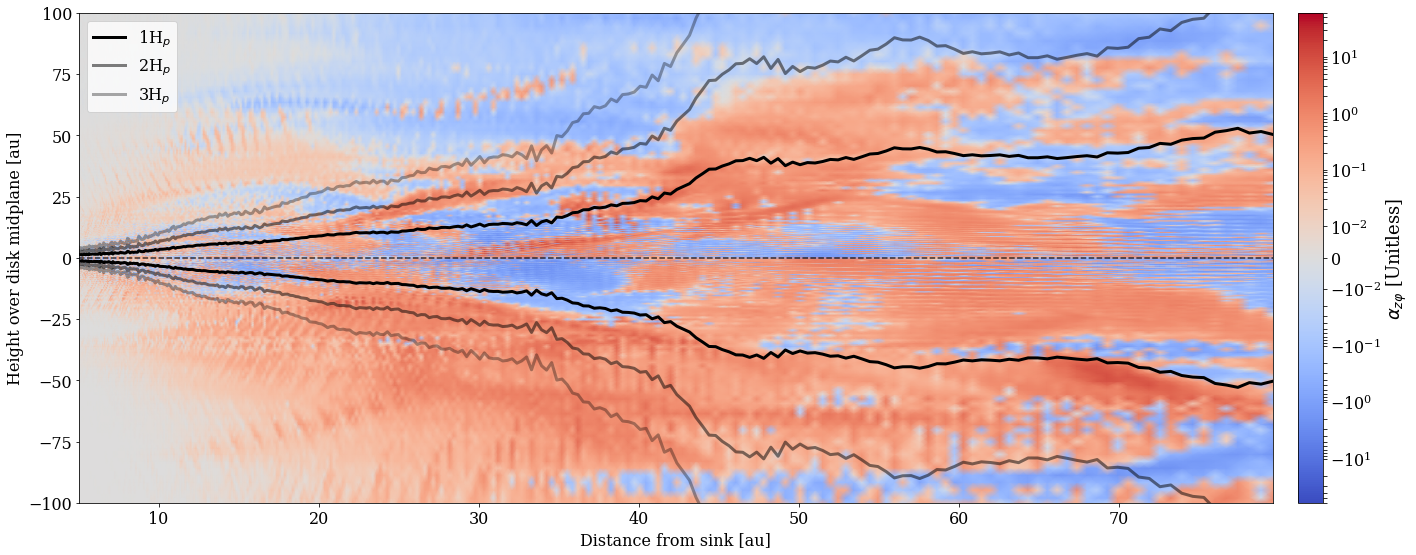

In [8]:
fig, axs = plt.subplots(figsize = (20, 8))

cs = axs.pcolormesh(radii * data.au_length, z_bins * data.au_length, total.T, norm = colors.SymLogNorm(linthresh=1e-2, linscale=0.5, vmin = -6e1, vmax = 6e1), cmap = 'coolwarm', shading = 'gouraud')
cbar = fig.colorbar(cs, ax=axs, fraction = 0.04, pad = 0.02)
cbar.set_label('$α_{zφ}$ [Unitless]',fontsize = 18)
for i in range(1, 4):
    axs.plot(radii * data.au_length, i*data.H_1D[:,0], color = 'black', lw = 3, alpha = i**(-1))
    axs.plot(radii * data.au_length, -i*data.H_1D[:,0], color = 'black', lw = 3, alpha = i**(-1), label = f'{i}H$_p$')

axs.axhline(0, color = 'black', ls = '--', alpha = 0.75)

axs.set(ylabel = 'Height over disk midplane [au]', xlabel = 'Distance from sink [au]', ylim = (-100,100))
plt.legend()
plt.tight_layout()